In [222]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from _do_calculation import solve_mbes_general, solve_mbes, solve_mbes_without_cavity, get_pulses_from_cavity_field, solve_mbes_wait, solve_mbes_only_decay, solve_obes
from _mbes import mbes, mbes_soc, mbes_soc_no_cavity, mbes_soc_det, obes_soc, mbes_masing
import matplotlib
# matplotlib.use('NbAgg')
import numpy as np
from scipy.stats import logistic
from scipy.optimize import basinhopping
from scipy.special import erf
from scipy import interpolate
from IPython.display import clear_output, Javascript, Markdown
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import scipy.io
import gc
import datetime
import time
import random
import matplotlib
from _create_pdf import create_spins, create_spins_inhomo_g
from _helper_functions import get_thermal_photons, tsallis, cauchy, find_nearest, odeintz, find_nearest_sorted_left
from _steady_state import cav_steady, a_steady, a_steady_maser, a_steady_maser_temp, sz_steady_maser_from_a2, sz_steady_maser_from_a2_temp,  a2_steady_maser
from importlib import reload
import _spin_params as spin_pars
import _sys_helpers
_sys_helpers.copy_connection_file()
# matplotlib.pyplot.switch_backend('nbagg')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [243]:
gcoll = spin_pars.gcoll
q = spin_pars.q
quali = spin_pars.quali
fr = spin_pars.fr
kappa = np.pi*fr/quali  # HWHM
delta = spin_pars.delta  # detuning cavity to spin central frequency ws-wc
deltac = spin_pars.deltac  # detuning drive to cavity wc-wp
gperp = spin_pars.gperp  # HWHM
gpar = spin_pars.gpar  # 0.001 #HWHM
gammaq = spin_pars.gammaq
nbins = spin_pars.nbins  # 701#5000#20
nbins = 22001
g_number = spin_pars.g_number  # how many bins for inhomogeneous coupling
#g0 = gcoll/sqrt(nspins)
print(kappa)

4.143362827573153


In [244]:
def pulse_rwa(t, args):
    wgrund = args[0]
    fcomps = args[1]
    pulse = 0
    for i in range(len(fcomps)):
        pulse = pulse+(fcomps[i])*np.sin((i+1)*wgrund*t)
    return pulse


def pulse_rwa_gauss(t, args):
    wgrund = args[0]
    fcomps = args[1]
    nfcomps = len(fcomps)
    tend = np.pi/wgrund

    width = 2*tend/(nfcomps+5)
    t0 = 3*width/2
    pulse = 0
    for i in range(len(fcomps)):
        pulse += fcomps[i]*np.exp(-4*(t-t0)**2*np.log(2)/width**2)
        t0 += 0.5*width
    pulse *= logistic.cdf(t, loc=0.01, scale=.002) * \
        (1-logistic.cdf(t, loc=tend-0.01, scale=.002))
    pulse *= 0.46971947398573455
    return pulse


def pulse_rwa_gauss_const(t, args):
    wgrund = args[0]
    fcomps = args[1]
    maxampl = args[2]
    tend = np.pi/wgrund

    spline = 0
    for i in range(len(fcomps)):
        spline += (fcomps[i])*np.sin((i+1)*wgrund*t)
    pulsei = 0
    pulseq = 0
    pulse = 0
    pulse = maxampl*logistic.cdf(t, loc=0.02, scale=0.004) * \
        (1-logistic.cdf(t, loc=tend-0.02, scale=0.004))

    pulsei = pulse*np.cos(spline)
    pulseq = pulse*np.sin(spline)

    return pulsei, pulseq

In [245]:
def g_inhomo_function(x, sigma):
    return np.exp(-x**2/sigma**2)


x_start = 5
x_stop = 20  # µm
x = np.linspace(x_start, x_stop, g_number)
sigma = 5
g_temp = g_inhomo_function(x, sigma)
g_list = g_temp/np.sum(g_temp)

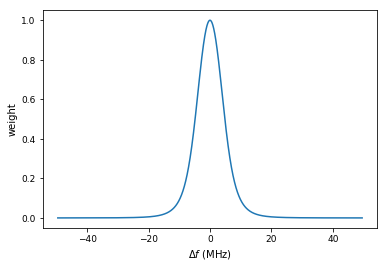

Cooperativity is: 8.276906


In [246]:
plt.close('all')
matplotlib.interactive(False)
spins, gs, pdf = create_spins_inhomo_g(
    gcoll, g_list, q, delta, gammaq, nbins, holes=False, inhomo=True, hyperfine=True)
plt.figure()
plt.plot(spins[:len(pdf)], pdf/max(pdf))
plt.xlabel('$\Delta f$ (MHz)')
plt.ylabel('weight')
plt.show()
# %qtconsole
coop = gcoll**2/kappa*np.sum(pdf/(gperp+1j*2*np.pi*spins))
print("Cooperativity is: %f" % coop.real)

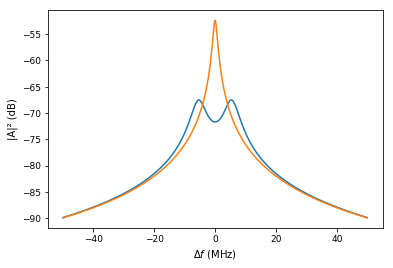

In [247]:
plt.close('all')
matplotlib.interactive(False)

initsteady = (0.001, 0.001)
fstart = 50
deltaarr = np.linspace(-fstart*2*np.pi, fstart*2*np.pi, 2000)
etasteady = 0.01
losasteady = np.zeros(np.shape(deltaarr))
losareal = np.zeros(np.shape(deltaarr))
losaimag = np.zeros(np.shape(deltaarr))

newinit = initsteady
for i, delt in enumerate(deltaarr):

    ar, ai = a_steady(etasteady, delt, gs, spins, gpar, gperp, kappa, newinit)
    newinit = (ar, ai)
    losasteady[i] = ai**2+ar**2
    losareal[i] = ar
    losaimag[i] = ai

fig = plt.figure()
plt.xlabel('$\Delta f$ (MHz)')
plt.ylabel('|A|² (dB)')
plt.plot(deltaarr/2/np.pi, 10*np.log10(losasteady))

ar, ai = cav_steady((fr*2*np.pi+deltaarr), fr*2*np.pi,  etasteady, kappa)
losasteady = ai**2+ar**2


plt.plot(deltaarr/2/np.pi, 10*np.log10(losasteady), '')

plt.show()

# Power Scan Steady State Resonant

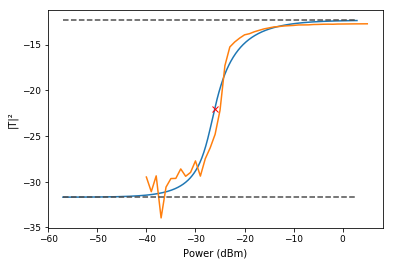

2013075576076097.8
8.266555645753396e-14


In [312]:
plt.close('all')
matplotlib.interactive(False)

powers = np.arange(-30, 30, 0.1)
detuning = 0
drs = 10**(powers/20.)

initsteady = (0.001, 0.001)
losasteady_p = np.zeros(np.shape(powers))
losareal_p = np.zeros(np.shape(powers))
losaimag_p = np.zeros(np.shape(powers))

newinit = (losareal[int(len(losareal)/2)], losaimag[int(len(losareal)/2)])
for i, dr in enumerate(drs):

    ar, ai = a_steady(dr, detuning, gs, spins, gpar, gperp, kappa, newinit)
    losasteady_p[i] = ai**2+ar**2
    losareal_p[i] = ar
    losaimag_p[i] = ai
    newinit = (ar, ai)

fig = plt.figure()
plt.xlabel('Power (dBm)')
plt.ylabel('|T|²')

data = scipy.io.loadmat(
    "/mnt/samba2/experiments/Quantum InterConnect/Cryogenics/Dilution Fridge/Measurements/20220223_DCR_n-diamond_33/vnaPowerScans/powerScan_S12_onres_7_mfile-v6", simplify_cells=True)

datax = data["measPars"]["vna"]["measPower"]
datay = np.array([trace['realpart']**2+trace['imagpart']
                 ** 2 for trace in data['traces']])


pows = powers-27


plt.plot(pows, 10*np.log10(losasteady_p/drs**2))

plt.plot(datax, 10*np.log10(datay)+64)


val1 = 10*np.log10(1/kappa**2)
val2 = 10*np.log10(1/(kappa+kappa*coop.real)**2)
mean = (val1+val2)/2

plt.plot([pows[0], pows[-1]], [val1, val1], '--', color=(0.3, 0.3, 0.3))
plt.plot([pows[0], pows[-1]], [val2, val2], '--', color=(0.3, 0.3, 0.3))


idx = find_nearest(10*np.log10(losasteady_p/drs**2), mean)

plt.plot(pows[idx], 10*np.log10(losasteady_p[idx]/drs[idx]**2), 'rx')

plt.show()

eta2 = (drs[idx]*1e3)**2/nbins*spin_pars.nreal
print(eta2)
k1 = 25e3
print(eta2*scipy.constants.Planck*fr*1e6/(2*k1))

# scipy.io.savemat("/home/andreas/wenz_daten.mat", {'power_sim': pows, 'y_sim': 10*np.log10(
#    losasteady_p/drs**2), 'power_data': datax, 'y_data': 10*np.log10(datay)+64})

In [257]:
%qtconsole